<a href="https://colab.research.google.com/github/1001shiyuan/Hurricane-Trajectory-Prediction/blob/master/hurricane_net_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/MyDrive/Hurricane-Trajectory-Prediction/docs

/content/gdrive/MyDrive/Hurricane-Trajectory-Prediction/docs


In [3]:
!ls

archive  hurricane-net-architecture.html  __init__.py
data	 hurricane-net-architecture.png
errors	 img


# hurricane-net
Hammad Usmani
### A machine learning algorithm to forecast the intensity and trajectory of Atlantic tropical storms
[https://github.com/hammad93/hurricane-net](https://github.com/hammad93/hurricane-net)

### Table of Contents

1. [Background](#Background)
2. [Problem](#Problem)
3. [Datasets](#Datasets)
4. [Workflow Diagram](#Workflow)
5. [Data Extraction](#Extract)
6. [Data Transformation](#Transform)
7. [Data Loading](#Load)
8. [Feature Engineering](#FeatureEngineering)
9. [Model Architecture](#ModelArchitecture)
11. [Model Selection](#ModelSelection)
12. [Paramater Optimization](#Optimization)
13. [Model Evaluation & Benchmarks](#Benchmarks)
14. [Visualizations](#Visualizations)

![Hurricane Maria 2017](img/hurricane-maria.png "Hurricane Maria. Source: NOAA")

## Background<a id="Background"></a>

The National Hurricane Center (NHC) and National Oceanic and Atmospheric Administration (NOAA) provide predictions for storms trajectories, intensity, and size. They create these predictions based on models that can be classified into 3 groups: dynamical, statistical, and ensemble [1]. The most accurate models are based on computational fluid dynamics and achieve more precision than their statistical and ensemble counterparts [1][4]. The current statistical models (OCD5) are based on multiple regression methods that can explain a significant amount of variance [1]. In this project, we research and implement the domain of machine learning and deep learning into predictive hurricane models for both trajectory and intensity and evaluate them against the NHC standards. 
Previous research into machine learning to forecast tropical Atlantic storms include a sparse recurrent neural network (Kordmahalleh, Sefidmazgi, & Homaifar, 2016) and an artificial neural network (Jung & Das, 2013); both achieved favorable results. The hurricane models created can be utilized to develop more precise emergency planning. There is a necessity for more accurate and timely models that can help reduce the amount of loss caused by hurricanes. 

## Problem<a id="Problem"></a>

The NOAA and NHC have several different classifications for Atlantic hurricane models that describe feature prediction and model architecture. The 3 main classifications for hurricane model architecture include dynamical, statistical, and ensemble. Classifications also include relative compute time required to create an output grouped as either early or late and forecast parameters such as trajectory, intensity, and wind radii. The most accurate models are late models that take upwards of 6 hours to produce an output whereas models that can produce an output in seconds to minutes are called early. Early models tend to be statistical which include the baseline model for trajectory named CLIPER5 Climatology and Persistence (CLP5) utilizing multivariate regression. The performance for these methods can be augmented by incorporating more advanced statistical methods from deep learning such as recurrent neural networks. Kordmahalleh et al., 2016 created a sparse recurrent neural network augmented by a genetic algorithm but there are factors requiring improvement. The training set utilized an older version of the NHC Hurricane Database format known as HURDAT while a new format has been released called HURDAT2 with additional information on wind radii. Kordmahalleh et al., 2016 also utilized benchmarks different from the standard applied within the NHC. Other than improving their methodology, we can expand the scope by creating separate models for both intensity and trajectory. These models can be used to predict the trajectory and intensity for future Atlantic storms.

## Datasets<a id="Datasets"></a>

The following datasets and inputs including their sources will be used to create machine learning models:
- NHC Hurricane Database (HURDAT2)
    - http://www.nhc.noaa.gov/data/#hurdat
    - https://www.kaggle.com/noaa/hurricane-database
- NHC Forecast Error Database
    - http://www.nhc.noaa.gov/verification/verify7.shtml
- NHC GIS
    - http://www.nhc.noaa.gov/gis/

*In the future, the IBTrACS database will be used to extend the hurricane-ai to additional regions.*

The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2016. The most updated version of the dataset is included on the noaa.gov site and includes 2 additional years of cyclone data compared to the data set available on Kaggle and is potentially more descriptive. To match the inputs of the baseline model used by the NHC, we are calculating the forward motion of the storm by applying a vector based on previous and current geographical location.

*Table 1. This table contains the tentative features as input to the model*

| **Name**         | **Data Type** | **Description**                                                     |
|------------------|---------------|---------------------------------------------------------------------|
| Time             | Date Time     | The date and time of the measurement.                               |
| Latitude         | Float         | The geographical latitude of the storm eye to 1 decimal precision.  |
| Longitude        | Float         | The geographical longitude of the storm eye to 1 decimal precision. |
| Maximum Winds    | Integer       | The maximum sustained winds within the storm.                       |
| Minimum Pressure | Integer       | The minimum barometric pressure within the storm.                   |
| Forward Motion   | String        | Calculated vector of motion based on location in time series.       |

The Forecast Error Database contains information on the accuracy of predicted models from the NHC. The two model forecast errors available are labeled OFCL and BCD5. The OFCL is the official NHC forecast and the BCD5 is the real track available. This data set can be used to benchmark and evaluate the deep learning model. 
The NOAA and NHC also hosts a geographical information system (GIS) that contains raw and processed data on hurricanes. The server hosting the GIS is publicly accessible and can be used to evaluate our model by comparing the 2017 Atlantic tropical season. The preliminary best tracks can be found here before they are finalized and available in the HURDAT2 data set. With the GIS, we can construct a final evaluation data set.

*Diagram 1. This graphic describes the workflow for the deep learning models*.<a id="Workflow"></a>
![Data Pipeline](img/Deep Learning Workflow.png "hurricane-net Data Pipeline")

## Extract Data<a id="Extract"></a>

*The following code uses the hurdat2 and models modules created to provide a class interface for the HURDAT2 and error forecast database located in the data and models folder. *

We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL. Although we're dividing these steps into disctinct procedures, they are often more fluid and often have overlaps. The extraction phase consists of collecting and parsing the HURDAT2 and error forecast databases for analysis and benchmarking. The HURDAT2 database is our core foundation for creating the deep learning model. We store the database in its raw .txt format but it can be directly linked to the database hosted by the NHC.

In [3]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import dateutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from geopy.distance import great_circle as vc
import math as Math
# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
# dataset = hurdat2("data/hurdat2.txt")
dataset = hurdat2("data/hurdat2-1851-2022-050423.txt") # Note that this data includes up to and including 2016
errors = models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44681,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44682,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44683,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44684,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44685,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): 0.0,
                                      datetime.datetime(2005, 8, 29, 6, 0): 20.9,
                                      datetime.datetime(2005, 8, 29, 18, 0): 93.6,
                                      datetime.datetime(2005, 8, 30, 6, 0): 170.2,
                                      datetime.datetime(2005, 8, 30, 18, 0): None,
                                      datetime.datetime(2005, 8, 31, 18, 0): None,
                                      datetime.datetime(2005, 9, 1, 18, 0): None,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 26.3,
        'long': 88.6,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 

In [8]:
def add_direc_of_travel(data, total_data_count):
  data['distance'] = np.zeros(total_data_count)
  data['direction'] = np.zeros(total_data_count)

  # For all hurricanes
  for x in range(0, total_hurricane_count):
      t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
      dst = 0
      prev = (0,0)
      
      # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
      for p in zip(t['Lat'], t['Long']):
          
          if prev == (0,0):
              prev = p
              continue 
          # Stores the distance into the DataFrame
          data.at[t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'distance'] = vc(prev,p).miles
          
          dLon = p[1] - prev[1];  
          temp = float(p[0]) # p[0] is a str?
          y_x = Math.sin(dLon) * Math.cos(temp);
          
          x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
          brng = Math.degrees(Math.atan2(y_x, x_x)) 
          if (brng < 0):
              brng+= 360;
          
          # Stores the angle of travel into the DataFrame
          data.at[t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction'] = brng
          dst += vc(prev,p).miles
          prev = p

  

ValueError: ignored

## Transform Data<a id="Transform"></a>

The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a `storm_id` dictionary to store storm names matched with ID's.

In [11]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : 980 if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_ids = dict()

# Parse in hurricanes
hurricanes = dict()
print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")


Transforming HURDAT2 into objects . . .
Transforming 53976/53976 entries from HURDAT2
Done!


In [10]:
storm_ids

NameError: ignored

In [8]:
print(set(hurricanes.keys()))

{'AL071948', 'AL141998', 'AL081994', 'AL061995', 'AL162000', 'AL091990', 'AL121934', 'AL091903', 'AL061931', 'AL041885', 'AL031953', 'AL041932', 'AL051878', 'AL061944', 'AL182005', 'AL181979', 'AL091997', 'AL041976', 'AL011981', 'AL051889', 'AL041983', 'AL011991', 'AL102015', 'AL051861', 'AL051974', 'AL022008', 'AL091878', 'AL061985', 'AL031989', 'AL112019', 'AL021938', 'AL202005', 'AL061976', 'AL101949', 'AL021991', 'AL051916', 'AL201981', 'AL021875', 'AL171933', 'AL011922', 'AL151975', 'AL121893', 'AL051899', 'AL021986', 'AL051955', 'AL082016', 'AL071880', 'AL011884', 'AL091924', 'AL091934', 'AL012021', 'AL041950', 'AL041861', 'AL122003', 'AL112012', 'AL051971', 'AL041923', 'AL011949', 'AL201979', 'AL202019', 'AL011890', 'AL071972', 'AL071888', 'AL142008', 'AL141944', 'AL041959', 'AL111988', 'AL011990', 'AL011904', 'AL061957', 'AL141966', 'AL031902', 'AL141959', 'AL022019', 'AL051954', 'AL141995', 'AL021928', 'AL071865', 'AL051919', 'AL071937', 'AL181933', 'AL011853', 'AL141974', 'AL

## Load Data<a id="Load"></a>

The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [14]:
# Get all available model errors
models = errors.models.keys()
# Load model errors into hurricanes
for id in storm_ids :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in errors.models[model].storm :
            continue
        hurricanes[id].add_model(model, errors.models[model].storm[id])

In [10]:
models

dict_keys(['OFCL', 'BCD5'])

## Feature Engineering & Data Augmentation<a id="FeatureEngineering"></a>

The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.

1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [15]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    
    timestep = {
      'lat' : float,
      'long' : float,
      'max-wind' : float,
      'entry-time' : datetime
    }
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
        'delta_pressure': (timestep['min_pressure'] - previous['min_pressure']) /
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200)
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-15-931273366cdf>:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(x) is 0 :


Feature engineered 1944/1952 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1952/1952 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


In [17]:
processed_data

{'x': array([[[ -0.45535714,  -0.22053232,   0.25      , ...,   0.13333333,
           -0.5       ,   0.        ],
         [ -0.5       ,  -0.29277567,   0.25      , ...,   0.13333333,
           -1.        ,   0.        ],
         [ -0.54464286,  -0.36121673,   0.        , ...,   0.06666667,
            0.5       ,   0.        ],
         [ -0.58035714,  -0.42965779,   0.        , ...,   0.06666667,
            0.        ,   0.        ],
         [ -0.60714286,  -0.48669202,  -0.25      , ...,   0.06666667,
           -0.5       ,   0.        ]],
 
        [[ -0.41071429,  -0.14448669,   0.5       , ...,   0.13333333,
            0.        ,   0.        ],
         [ -0.45535714,  -0.22053232,   0.25      , ...,   0.13333333,
           -0.5       ,   0.        ],
         [ -0.5       ,  -0.29277567,   0.25      , ...,   0.13333333,
           -1.        ,   0.        ],
         [ -0.54464286,  -0.36121673,   0.        , ...,   0.06666667,
            0.5       ,   0.        ],
  

## Model Architecture<a id="ModelArchitecture"></a>

Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

Notes:
- We will use 500 epochs for wind intensity because the validation loss is not decresing
- We will use 1,000 epochs for latitute and longitude

In [18]:
from keras.models import Sequential

In [19]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)


In [20]:

# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)

# Train for min pressure
y_train_pressure = np.array([[[features[4]] for features in y] for y in y_train], dtype = np.float64)
y_test_pressure = np.array([[[features[4]] for features in y] for y in y_test], dtype = np.float64)

def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adadelta')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

def lstm_td(X_train, X_test, y_train, y_test) :
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (5,8), return_sequences = True))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    model.fit(X_train, y_train, batch_size = len(X_train), epochs = 300)
    
    return model

model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)
model_lat, model_lat_history = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 1000)
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long, n_epochs = 1000)
model_pressure, model_pressure_history = bd_lstm_td(X_train, y_train_pressure, X_test, y_test_pressure, n_epochs = 500)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 432ms/step - loss: 1.2608 - val_loss: 1.2374
Epoch 20/1000
1/1 [==============================] - 0s 436ms/step - loss: 1.2603 - val_loss: 1.2368
Epoch 21/1000
1/1 [==============================] - 0s 424ms/step - loss: 1.2594 - val_loss: 1.2361
Epoch 22/1000
1/1 [==============================] - 0s 443ms/step - loss: 1.2586 - val_loss: 1.2355
Epoch 23/1000
1/1 [==============================] - 0s 432ms/step - loss: 1.2582 - val_loss: 1.2349
Epoch 24/1000
1/1 [==============================] - 0s 444ms/step - loss: 1.2579 - val_loss: 1.2343
Epoch 25/1000
1/1 [==============================] - 0s 437ms/step - loss: 1.2572 - val_loss: 1.2337
Epoch 26/1000
1/1 [==============================] - 0s 438ms/step - loss: 1.2561 - val_loss: 1.2331
Epoch 27/1000
1/1 [==============================] - 0s 452ms/step - loss: 1.2550 - val_loss: 1.2325
Epoch 28/1000
1/1 [==============================] - 0

## Model Selection<a id="Selection"></a>
The following models were compared
- Bidirectional LSTM with Time Distributed(Best performance)
- LSTM with Time Distributed
- MLP
- Bidirectional GRU with Time Distributed

83/83 [==============================] - 0s 3ms/step
Wind


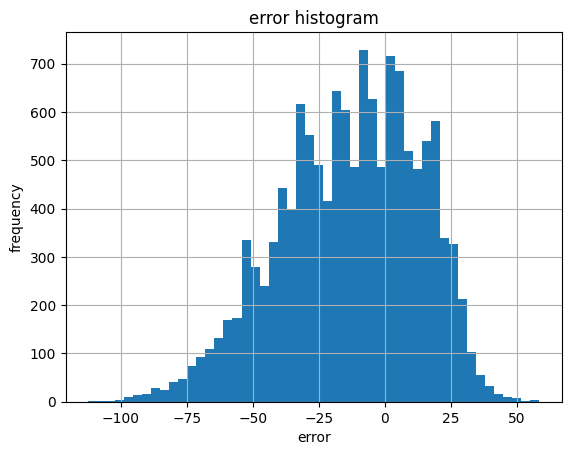

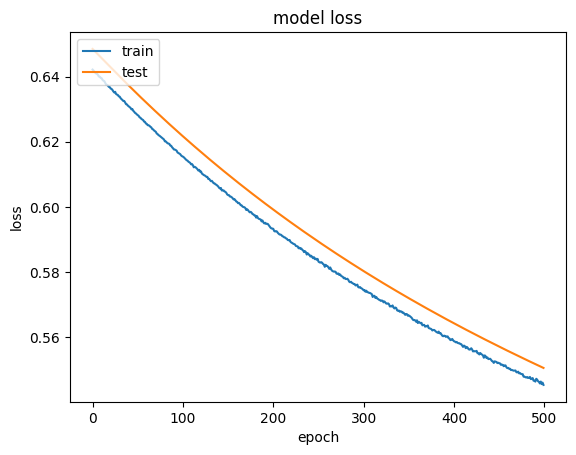

,0
count,13245.000000
mean,-13.409345
std,26.477203
min,-112.422066
25%,-32.290502
50%,-10.815530
75%,6.653621
max,58.496304


In [24]:
def ai_errors(predictions, observations, history = None) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
             history - Keras history model for displaying model loss, default is None if not available
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
    
    # Display history and erros
    plt.figure(1)
    plt.hist(errors, bins = 50)
    plt.title('error histogram')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.grid(True)
    
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return pd.DataFrame(errors)

# Predict values
wind_predictions = model_wind.predict(X_test)
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)
pressure_predictions = model_pressure.predict(X_test)
# Scale back our predictions
# Wind
wind_predictions_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

# Wind
pressure_predictions_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0] for pressure in prediction])
                           for prediction in pressure_predictions]
y_pressure_test_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0] for pressure in observation])
                      for observation in y_test_pressure]
# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[2] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[2] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]

# Present Errors
ai_errors(wind_predictions, wind_observations, model_wind_history).describe()

Lat


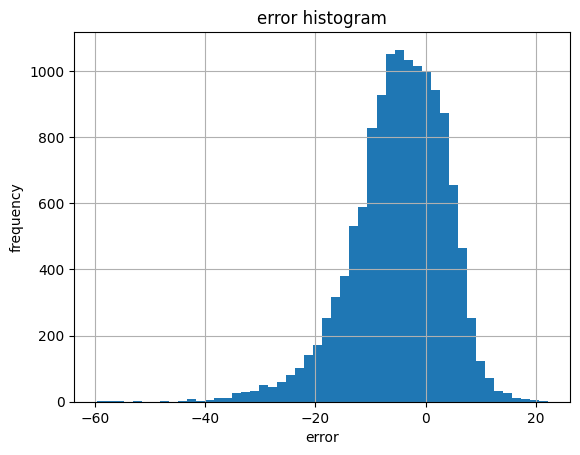

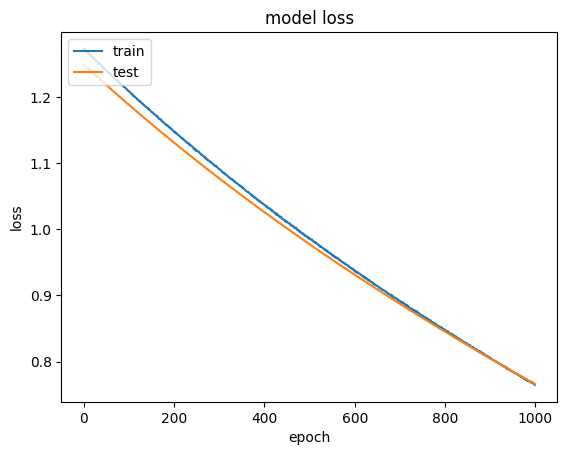

,0
count,13245.000000
mean,-4.894767
std,8.493244
min,-59.656236
25%,-9.663905
50%,-4.215882
75%,1.152189
max,22.164780


In [25]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations, model_lat_history).describe()

Long


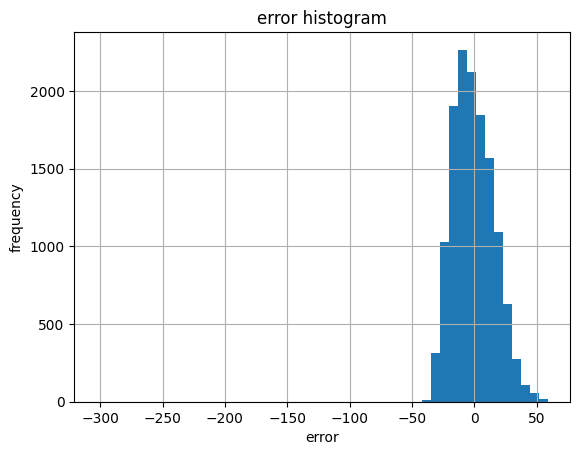

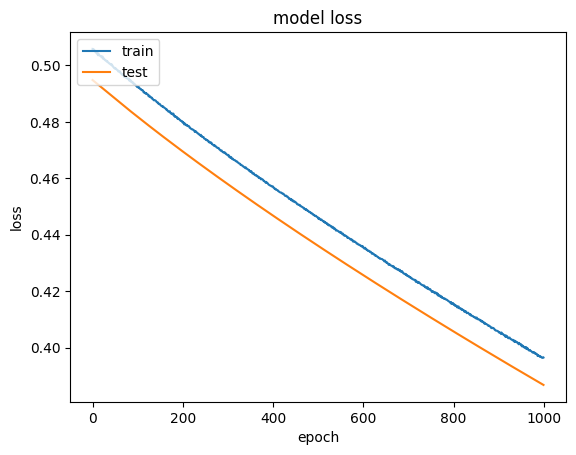

,0
count,13245.000000
mean,-1.005967
std,16.325717
min,-302.636735
25%,-13.290344
50%,-2.466685
75%,10.201249
max,58.890999


In [26]:
print("Long")
long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations, model_long_history).describe()

Pressure


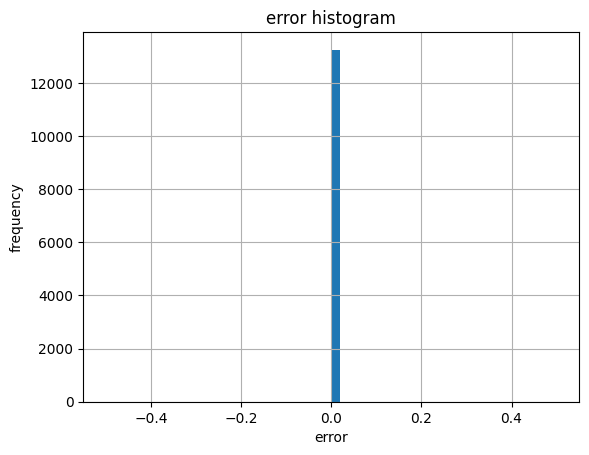

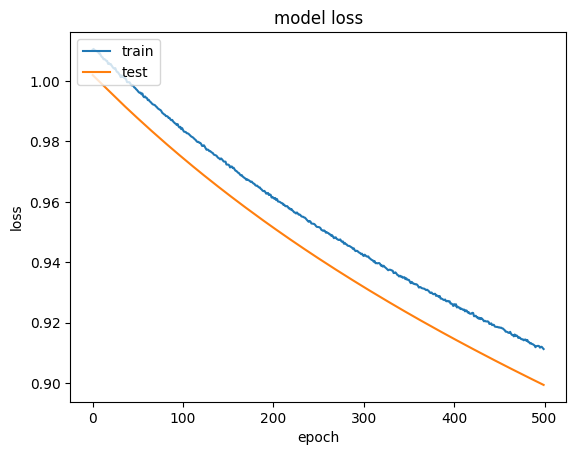

,0
count,13245.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [27]:
print("Pressure")
pressure_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in pressure_predictions_scaled]
pressure_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_pressure_test_scaled]
ai_errors(pressure_predictions, pressure_observations, model_pressure_history).describe()

## Model Evaluation & Benchmarks<a id="Benchmarks"></a>

The machine learning neural network will use 2 main methods of applied evaluation. The first will be evaluated compared to the other models that predict Atlantic hurricanes. The forecast errors have been loaded into each hurricane object corresponding to their forecast model; both the OFCL (official track) and the BCD5 (model using multivariate regression). The BCD5 model is "the CLP5 (track) and DSF5 (intensity) models merged" that uses the best track as input. BCD5 is similar to OCD5 except for the inputs to the models. The *O* is for operational input while the *B* is for best track input. The best track is only available post-season and is better than the operational input.

### References
http://www.hurricanecity.com/models/models.cgi?page=models

In [28]:
test_data = hurdat2('data/hurdat2-1851-2017-050118.txt')

# Parse in hurricanes
hurricanes_2017 = dict()
print("Transforming 2017 HURDAT2 into objects . . .")
for index, entry in test_data.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # Filter to capture 2017 data
    if entry['storm_id'][-4:] != '2017' :
        continue
    if entry['storm_id'] not in hurricanes_2017 :
        hurricanes_2017[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes_2017[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

# Filter storms that have more than 6 entries. We need at least 6 to calculate 5 speed vectors
storms_filter = [storm for storm in hurricanes_2017.values() if len(storm.entries) > 6]

# Begin creating hurricane forecast and track predictions
tracks = {
    'storms' : [], # Reference storm
    'inputs' : [], # The inputs for the ai
    'valid_times' : [], # The valid time to compare to the error database
}
for index, storm in enumerate(storms_filter) :
    # Create inputs to ai. ai requires scaled data as input
    entries = [entry[1] for entry in sorted(storm.entries.items())] # Extracts data from data structure
    
    # Scale the entries
    for start_index in range(1, len(entries) - 5) : # Go through each entry
        # Build feature extraction
        extracted_features = []
        valid_time = None # Going to be set to the last element in the series
        for pivot in range(start_index, start_index + 5) :
            extracted_features.append(np.array(list(feature_extraction(entries[pivot], entries[pivot - 1]).values())))
            if pivot is start_index + 4 : # We're on the last element
                valid_time = entries[pivot]['entry_time']
        
        # If there's an incomplete value we can't process, skip it
        if any(None in entry for entry in extracted_features) :
            continue
            
        # Scale extracted features        
        scaled_entries = scaler.transform(extracted_features)
        
        # Add to our results
        tracks['storms'].append(storm)
        tracks['inputs'].append(scaled_entries.tolist())
        tracks['valid_times'].append(valid_time)
        
    print("\rDone with track processing {}/{} storms".format(index + 1, len(storms_filter)), end = '')
tracks['inputs'] = np.array(tracks['inputs'])

Transforming 2017 HURDAT2 into objects . . .
Transforming 50303/53976 entries from HURDAT2
Done!
Done with track processing 18/18 storms

In [29]:
tracks['wind_predictions_raw'] = model_wind.predict(tracks['inputs'])
tracks['lat_predictions_raw'] = model_lat.predict(tracks['inputs'])
tracks['long_predictions_raw'] = model_long.predict(tracks['inputs'])
tracks['pressure_predictions_raw'] = model_pressure.predict(tracks['inputs'])

16/16 [==============================] - 0s 4ms/step


In [30]:
# Define a function to return the distance between two coordinates in nautical miles
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d * 0.539957 # km to nautical miles

In [31]:
# Scale back and store our wind predictions and our lat, long predictions
tracks['wind_predictions'] = []
tracks['lat_predictions'] = []
tracks['long_predictions'] = []
tracks['pressure_predictions'] = []
intensity_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
track_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
pressure_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
for index, prediction in enumerate(tracks['wind_predictions_raw']) :
    # Use our standard scaler to scale the raw predictions back
    winds_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0] for winds in prediction])] # Index 2 is winds
    lat_scaled = [scaler.inverse_transform([[lats[0],0,0,0,0,0,0,0,0,0,0,0] for lats in tracks['lat_predictions_raw'][index]])] # Index 0 is lat
    long_scaled = [scaler.inverse_transform([[0,longs[0],0,0,0,0,0,0,0,0,0,0] for longs in tracks['long_predictions_raw'][index]])] # Index 1 is long
    pressure_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0] for pressure in tracks['pressure_predictions_raw'][index]])]
    # Extract the wind prediction from data structure and store into new data structure
    for i in range(len(winds_scaled)) :        
        # The new data structure is a tuple of (wind, storm_id, valid_time, forecast_time)
        wind_predictions = []
        lat_predictions = []
        long_predictions = []
        pressure_predictions = []
        for step, pred in enumerate(winds_scaled[i]) :
            wind = pred[2]
            lat = lat_scaled[i][step][0]
            long = long_scaled[i][step][1]
            pressure = pressure_scaled[i][step][4]
            storm_id = tracks['storms'][index].id
            valid_time = tracks['valid_times'][index]
            forecast_time = valid_time + datetime.timedelta(days = step + 1)
            
            # See if we can find the error
            if forecast_time in hurricanes_2017[storm_id].entries :
                wind_truth = hurricanes_2017[storm_id].entries[forecast_time]['max_wind']
                lat_truth = hurricanes_2017[storm_id].entries[forecast_time]['lat']
                long_truth = hurricanes_2017[storm_id].entries[forecast_time]['long']
                pressure_truth = hurricanes_2017[storm_id].entries[forecast_time]['min_pressure']
                intensity_error = abs(wind_truth - wind)
                track_error = distance((lat_truth,long_truth), (lat, long))
                pressure_error = abs(pressure_truth - pressure)

                wind_predictions.append({
                    'ai-wind' : wind,
                    'truth' : wind_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                lat_predictions.append({
                    'ai-lat' : lat,
                    'truth' : lat_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                long_predictions.append({
                    'ai-long' : long,
                    'truth' : long_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                pressure_predictions.append({
                    'ai-pressure' : pressure,
                    'truth' : pressure_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                if step == 0 :
                    intensity_errors['24'].append(intensity_error)
                    track_errors['24'].append(track_error)
                    pressure_errors['24'].append(pressure_error)
                if step == 1 :
                    intensity_errors['48'].append(intensity_error)
                    track_errors['48'].append(track_error)
                    pressure_errors['48'].append(pressure_error)
                if step == 2 :
                    intensity_errors['72'].append(intensity_error)
                    track_errors['72'].append(track_error)
                    pressure_errors['72'].append(pressure_error)
                if step == 3 :
                    intensity_errors['96'].append(intensity_error)
                    track_errors['96'].append(track_error)
                    pressure_errors['96'].append(pressure_error)
                if step == 4 :
                    intensity_errors['120'].append(intensity_error)
                    track_errors['120'].append(track_error)
                    pressure_errors['120'].append(pressure_error)
                    
        tracks['wind_predictions'].append(wind_predictions)
        tracks['lat_predictions'].append(lat_predictions)
        tracks['long_predictions'].append(long_predictions)
        tracks['pressure_predictions'].append(pressure_predictions)

In [32]:
pd.DataFrame(intensity_errors['24']).describe()

,0
count,432.000000
mean,26.258872
std,21.222358
min,0.109277
25%,12.284898
50%,20.678690
75%,32.092721
max,97.282073


In [33]:
pd.DataFrame(intensity_errors['48']).describe()

,0
count,378.000000
mean,26.495488
std,20.622115
min,0.058209
25%,11.813177
50%,23.054299
75%,32.213285
max,100.619318


In [34]:
pd.DataFrame(intensity_errors['72']).describe()

,0
count,327.000000
mean,26.351545
std,20.785840
min,0.045458
25%,12.027475
50%,22.979993
75%,33.841660
max,106.461050


In [35]:
pd.DataFrame(intensity_errors['96']).describe()

,0
count,285.000000
mean,26.094815
std,20.605806
min,0.139327
25%,10.659015
50%,22.738690
75%,35.412714
max,103.568124


In [36]:
pd.DataFrame(intensity_errors['120']).describe()

,0
count,249.000000
mean,26.473893
std,20.872034
min,0.108917
25%,12.095644
50%,22.256831
75%,34.335815
max,96.576952


In [37]:
pd.DataFrame(track_errors['24']).describe()

,0
count,432.000000
mean,1120.597827
std,530.597949
min,170.722294
25%,727.872449
50%,1085.225060
75%,1495.890501
max,3097.377671


In [38]:
pd.DataFrame(track_errors['48']).describe()

,0
count,378.000000
mean,1062.956288
std,512.665605
min,240.533054
25%,671.473075
50%,986.757976
75%,1417.519458
max,2913.495521


In [ ]:
pd.DataFrame(track_errors['72']).describe()

In [28]:
pd.DataFrame(track_errors['96']).describe()

,0
count,285.000000
mean,1123.232716
std,543.077360
min,275.588315
25%,672.551118
50%,971.124601
75%,1510.764970
max,2784.702670


In [39]:
pd.DataFrame(track_errors['120']).describe()

,0
count,249.000000
mean,1040.742563
std,548.818147
min,104.048288
25%,648.050598
50%,880.520179
75%,1450.400398
max,2722.075201


In [40]:
# Compare predictions when we can find them
import errors
errordb = errors.models.models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")
ai_wind_errors = []
ai_track_errors = []
bcd5_wind_errors = []
bcd5_track_errors = []
for index, prediction in enumerate(tracks['wind_predictions']) :
    # Find the time stamp for the storm ID in the error database
    if prediction == [] :
      continue
    valid_time = prediction[0]['valid_time']
    storm_id = prediction[0]['storm_id']
    # Check to see if we have error for this storm and at the valid time
    if storm_id in errordb.models['BCD5'].storm and valid_time in errordb.models['BCD5'].storm[storm_id] :
        print("Found {} at {}".format(storm_id, valid_time))
        # If we find it, compare
        for i, forecast in enumerate(prediction) :
            # See if we can find another prediction like that in the error database
            if errordb.models['BCD5'].storm[storm_id][valid_time]['intensity_forecast'][forecast['forecast_time'].to_pydatetime()] :
                print("\tIntensity Truth: {}, AI forecast: {}, BCD5 forecast: {}".format(forecast['truth'],
                                                                                         forecast['ai-wind'],
                                                                                         errordb.models['BCD5'].storm[storm_id][valid_time]['track_forecast'][forecast['forecast_time'].to_pydatetime()]))
                print("\tTrajectory Truth: {}, {}; AI forecast: {}, {} ; AI error: {} BCD5 error: {}".format(tracks['lat_predictions'][index][i]['truth'],
                                                                                                       tracks['long_predictions'][index][i]['truth'],
                                                                                                       tracks['lat_predictions'][index][i]['ai-lat'],
                                                                                                       tracks['long_predictions'][index][i]['ai-long'],
                                                                                                       distance((tracks['lat_predictions'][index][i]['truth'], tracks['long_predictions'][index][i]['truth']), (tracks['lat_predictions'][index][i]['ai-lat'], tracks['long_predictions'][index][i]['ai-long'])),
                                                                                                       errordb.models['BCD5'].storm[storm_id][valid_time]['intensity_forecast'][forecast['forecast_time'].to_pydatetime()]
                                                                                                      ))
                ai_wind_errors.append(abs(forecast['truth'] - forecast['ai-wind']))
                ai_track_errors.append(abs(distance((tracks['lat_predictions'][index][i]['truth'], tracks['long_predictions'][index][i]['truth']), (tracks['lat_predictions'][index][i]['ai-lat'], tracks['long_predictions'][index][i]['ai-long']))))
                bcd5_wind_errors.append(abs(errordb.models['BCD5'].storm[storm_id][valid_time]['track_forecast'][forecast['forecast_time'].to_pydatetime()]))                
                bcd5_track_errors.append(abs(errordb.models['BCD5'].storm[storm_id][valid_time]['intensity_forecast'][forecast['forecast_time'].to_pydatetime()]))

Found AL012017 at 2017-04-20 06:00:00
	Intensity Truth: 45.0, AI forecast: 49.922380722127855, BCD5 forecast: -19.0
	Trajectory Truth: 40.0, 46.3; AI forecast: 23.89686279296875, 62.11983085470274 ; AI error: 1254.5389965116417 BCD5 error: 391.5
Found AL012017 at 2017-04-20 12:00:00
Found AL012017 at 2017-04-20 18:00:00
Found AL012017 at 2017-04-21 00:00:00
Found AL012017 at 2017-04-21 06:00:00
Found AL032017 at 2017-06-21 00:00:00
	Intensity Truth: 45.0, AI forecast: 52.79898256063461, BCD5 forecast: 15.0
	Trajectory Truth: 28.5, 93.4; AI forecast: 23.482796239852906, 63.98878446668386 ; AI error: 1611.3780048772726 BCD5 error: 42.6
Found AL032017 at 2017-06-21 06:00:00
	Intensity Truth: 45.0, AI forecast: 51.46492660045624, BCD5 forecast: 11.0
	Trajectory Truth: 29.4, 93.6; AI forecast: 23.03698847293854, 64.09069722220302 ; AI error: 1629.947845976139 BCD5 error: 36.6
Found AL032017 at 2017-06-21 12:00:00
	Intensity Truth: 40.0, AI forecast: 52.06330478191376, BCD5 forecast: 13.0
	T

In [31]:
pd.DataFrame(ai_wind_errors).describe()

,0
count,997.000000
mean,34.422137
std,27.445393
min,0.086743
25%,12.332398
50%,27.308779
75%,50.385195
max,107.685952


In [32]:
pd.DataFrame(bcd5_wind_errors).describe()

,0
count,997.000000
mean,17.656971
std,15.179471
min,0.000000
25%,6.000000
50%,13.000000
75%,26.000000
max,79.000000


In [33]:
pd.DataFrame(ai_track_errors).describe()

,0
count,997.000000
mean,997.406095
std,488.626847
min,154.882521
25%,634.849012
50%,934.169383
75%,1187.469225
max,2334.247018


In [34]:
pd.DataFrame(bcd5_track_errors).describe()

,0
count,997.000000
mean,249.861785
std,225.954794
min,5.800000
25%,72.800000
50%,176.900000
75%,366.100000
max,1164.700000


In [35]:
tracks['inputs'][:1]

array([[[ 1.18253968, -0.23901582,  0.28571429,  0.        ,
         -0.55      , -2.        , -1.25      ,  1.        ,
         -5.        , -0.0625    ,  0.4       ],
        [ 1.12698413, -0.26713533,  0.28571429,  0.        ,
         -0.7       , -2.        , -1.25      ,  1.        ,
         -5.        , -0.0625    ,  0.8       ],
        [ 1.07142857, -0.29876977,  0.14285714, -1.        ,
         -0.65      , -2.        , -1.33333333,  1.        ,
         -5.        ,  0.        , -0.4       ],
        [ 1.03174603, -0.32688928,  0.        , -1.        ,
         -0.6       , -1.6       , -1.25      ,  1.        ,
         -5.        ,  0.        ,  0.        ],
        [ 0.99206349, -0.35852373,  0.        ,  0.        ,
         -0.55      , -1.6       , -1.33333333,  1.        ,
         -5.        ,  0.        ,  0.4       ]]])

In [36]:
[output[2] for output in 
 scaler.inverse_transform(
     [[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in model_wind.predict(tracks['inputs'][:1])[0]]
 )]

1/1 [==============================] - 0s 24ms/step


[47.72679101675749,
 48.78862038254738,
 48.46569649875164,
 47.401592172682285,
 45.882226610556245]

In [37]:
def hurricane_ai(input):
  '''
  input = {
    -120 : timestep,
    -96 : timestep,
    -72 : timestep,
    -48 : timestep,
    -24 : timestep,
    0 : timestep
  }
  output = {
    24 : prediction,
    48 : prediction,
    72 : prediction,
    96 : prediction,
    120 : prediction
  }
  timestep = {
      'lat' : float,
      'long' : float,
      'max-wind' : float,
      'min_pressure' : float,
      'entry-time' : datetime
  }
  prediction = {
    'lat' : float,
    'long' : float,
    'max-winds' : float
  }
  '''
  # Take entries and transform them into our data model
  extract = []
  temp = None
  for index, value in enumerate([-120, -96, -72, -48, -24, 0]):
    if not index :
      temp = input[value]
      continue
    else:
      extract.append(list(feature_extraction(input[value], temp).values()))
      temp = input[value]
  
  state = np.expand_dims(scaler.transform(extract), axis = 0)
  print('extract: {}, state: {}'.format(extract, state))
  # Finally, use our hurricane ai to predict storm state
  lat = [output[0] for output in scaler.inverse_transform(
      [[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in model_lat.predict(state)[0]])]
  long = [output[1] for output in scaler.inverse_transform(
      [[0,long[0],0,0,0,0,0,0,0,0,0] for long in model_long.predict(state)[0]])]
  wind = [output[2] for output in scaler.inverse_transform(
      [[0,0,wind[0],0,0,0,0,0,0,0,0] for wind in model_wind.predict(state)[0]])]
   
  output = dict()
  for index, value in enumerate([24, 48, 72, 96, 120]) :
    output[value] = {
        'lat' : lat[index],
        'long' : long[index],
        'max_wind' : wind[index]
    }
  
  return output

In [39]:
from dateutil.parser import parse
input = {
  0 : {
      'entry_time' : parse('Fri Aug 30 2019 1100 PM'),
      'lat' : 25.5,
      'long' : 71.4,
      'max_wind' : 140 / 1.51 , # mph to knots
      'min_pressure' : 948.0
    },
  -24 : {
      'entry_time' : parse('Thu Aug 29 2019 1100 PM'),
      'lat' : 23.3,
      'long' : 68.4,
      'max_wind' : 105 / 1.51 , # mph to knots
      'min_pressure' : 977.0
    },
  -48 : {
      'entry_time' : parse('Wed Aug 28 2019 1100 PM'),
      'lat' : 19.7,
      'long' : 66.0,
      'max_wind' : 85 / 1.51 , # mph to knots
      'min_pressure' : 986.0
    },
  -72 : {
      'entry_time' : parse('Tue Aug 27 2019 1100 PM'),
      'lat' : 16.0,
      'long' : 63.0,
      'max_wind' : 50 / 1.51 , # mph to knots
      'min_pressure' : 1006.0
    },
  -96 : {
      'entry_time' : parse('Mon Aug 26 2019 1100 PM'),
      'lat' : 13.2,
      'long' : 59.7,
      'max_wind' : 50 / 1.51 , # mph to knots
      'min_pressure' : 1003.0
    },
  -120 : {
      'entry_time' : parse('Sun Aug 25 2019 1100 PM'),
      'lat' : 11.7,
      'long' : 55.3,
      'max_wind' : 50 / 1.51 , # mph to knots
      'min_pressure' : 1003.0
    }
}


In [40]:
hurricane_ai(input)

extract: [[13.2, 59.7, 33.11258278145695, 0.0, 1003.0, 0.0625, 0.18333333333333357, 2019, 8, 26, 23], [16.0, 63.0, 33.11258278145695, 0.0, 1006.0, 0.1166666666666667, 0.13749999999999987, 2019, 8, 27, 23], [19.7, 66.0, 56.29139072847682, 11.589403973509935, 986.0, 0.15416666666666665, 0.125, 2019, 8, 28, 23], [23.3, 68.4, 69.5364238410596, 6.622516556291391, 977.0, 0.15000000000000005, 0.10000000000000024, 2019, 8, 29, 23], [25.5, 71.4, 92.71523178807946, 11.589403973509931, 948.0, 0.09166666666666663, 0.125, 2019, 8, 30, 23]], state: [[[-0.55555556  0.11950791 -0.33964049  0.          0.15
    0.15        0.33333333  1.125      -1.          0.5625
    1.13333333]
  [-0.33333333  0.23550088 -0.33964049  0.          0.3
    0.8         0.10416667  1.125      -1.          0.625
    1.13333333]
  [-0.03968254  0.34094903  0.32261116  1.1589404  -0.7
    1.25        0.04166667  1.125      -1.          0.6875
    1.13333333]
  [ 0.24603175  0.42530756  0.70104068  0.66225166 -1.15
    1.2  

{24: {'lat': 21.25751706957817,
  'long': 57.34351139329374,
  'max_wind': 46.73190778121352},
 48: {'lat': 22.545081627368926,
  'long': 58.04283459614962,
  'max_wind': 48.29919803887606},
 72: {'lat': 24.335165071487424,
  'long': 58.701074599847196,
  'max_wind': 50.07107838988304},
 96: {'lat': 26.03364340662956,
  'long': 59.0436025429517,
  'max_wind': 51.35034926235676},
 120: {'lat': 27.577855026721952,
  'long': 59.306639136746526,
  'max_wind': 52.32640214264393}}

In [ ]:
!git status

On branch master
Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.config/

nothing added to commit but untracked files present (use "git add" to track)
